# Galaxy Cluster Redshift Classification Using Machine Learning

Spring 2024 - PHYS 2550 - Final Project

*Jade Ducharme, Zacharias Escalante, Fei Fan, Soren Helhoski, Shi Yan*

This project aims to develop a machine learning model for classifying the redshifts of background
galaxies behind galaxy clusters using observational cosmology. By leveraging photometric proper-
ties of stars and galaxies, the project seeks to calculate new redshift values for each galaxy and
compare these with known spectroscopic redshift values to evaluate the model’s accuracy.

In [1]:
# import necessary packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"    # in case of library conflict, was unable to run program without this (Feifan)

import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

## Preprocessing

In [2]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag")

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51295, 7)
Label size [input_size,]:		 (51295,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


Let's visualize our inputs. First, we can plot the 1D histogram for any of our input features:

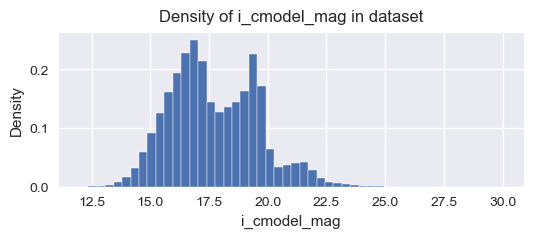

In [3]:
# Input visualization
from visualize import histogram_input

histogram_input(data, features, plot_feature="i_cmodel_mag", nbins=50, xrange=(12,30))

Next, we can also view how our labels align with any of the features in a 2D plot:

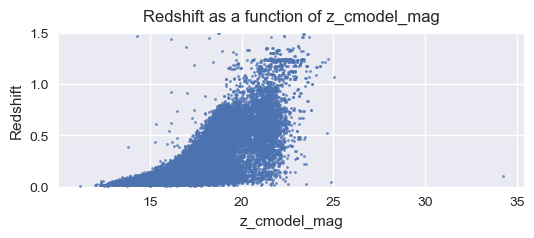

In [4]:
from visualize import plot_labels_features

plot_labels_features(data, labels, features, plot_feature="z_cmodel_mag", yrange=(0,1.5))

## 1D CNN

In [7]:
from preprocess import preprocess_split
from model import Simple1DCNN, train1D, test1D

# model initialization
model = Simple1DCNN(num_features=len(features), num_classes=1)

# Define the loss function and optimizer with weight decay
weight_decay = 1e-6  # Adjust this value as needed
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)  # Adding weight decay to Adam optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.000001)
acc_metric = torchmetrics.R2Score()


# Determine the device (CPU or GPU) for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The device is determined based on the availability of CUDA (GPU support) using torch.device.

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

# Train the model
num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []


for e in range(1,num_epochs+1):

    # training
    loss, acc = train1D(model, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test1D(model, device, test_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f'Epoch {e}: Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1: Train Loss: 0.1240, Train Acc: -0.0325, Val Loss: 0.1334, Val Acc: -0.0348
Epoch 2: Train Loss: 0.1095, Train Acc: -0.0258, Val Loss: 0.1197, Val Acc: -0.0204
Epoch 3: Train Loss: 0.0964, Train Acc: -0.0240, Val Loss: 0.1074, Val Acc: -0.0185
Epoch 4: Train Loss: 0.0850, Train Acc: -0.0157, Val Loss: 0.0967, Val Acc: -0.0166
Epoch 5: Train Loss: 0.0749, Train Acc: -0.0184, Val Loss: 0.0874, Val Acc: -0.0197
Epoch 6: Train Loss: 0.0661, Train Acc: -0.0207, Val Loss: 0.0793, Val Acc: -0.0298
Epoch 7: Train Loss: 0.0587, Train Acc: -0.0240, Val Loss: 0.0728, Val Acc: -0.0227
Epoch 8: Train Loss: 0.0525, Train Acc: -0.0322, Val Loss: 0.0669, Val Acc: -0.0299
Epoch 9: Train Loss: 0.0475, Train Acc: -0.0359, Val Loss: 0.0625, Val Acc: -0.0365
Epoch 10: Train Loss: 0.0436, Train Acc: -0.0486, Val Loss: 0.0591, Val Acc: -0.0480
Epoch 11: Train Loss: 0.0406, Train Acc: -0.0549, Val Loss: 0.0566, Val Acc: -0.0657
Epoch 12: Train Loss: 0.0384, Train Acc: -0.0670, Val Loss: 0.0547, Val Ac

In [8]:
# How does the model perform on unseen data?

model = Simple1DCNN(num_features=len(features), num_classes=1)  
model.eval()
test_loss, test_acc = test1D(model, device, test_loader, criterion, acc_metric)
print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.1908	 Final test acc: -0.0702


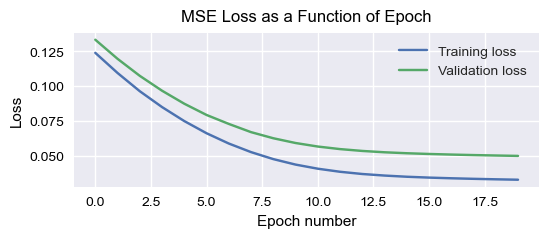

In [9]:
from visualize import plot_loss

plot_loss(loss_list, val_loss_list)

In [10]:
from model import get_predictions
from visualize import visualize_predictions

test_labels, test_preds = get_predictions(test_set, model, device=device, model_type='cnn')

visualize_predictions(test_labels, test_preds, "1D CNN", 
                      #savepath="./fcnn_preds.png", 
                      #transparent=True,
                      )

RuntimeError: Given groups=1, weight of size [16, 1, 3], expected input[1, 7, 1] to have 1 channels, but got 7 channels instead

## K-Nearest Neighbors Regression

In [ ]:
# Information about data

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag") #Load in data

# print("Data shape [input_size, num_features]:\t", data.shape) #Get data attributes
# print("Label size [input_size,]:\t\t", labels.shape,"\n")
# print("Feature names:", features)
# print(data)

In [ ]:
# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from visualize import visualize_knn_predictions

minmax_scaler = MinMaxScaler() #Method of scaling feature values
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

    # test_mse.append(mean_squared_error(test_labels, y_pred))

data_rescaled_minmax = minmax_scaler.fit_transform(data) #Scale feature data to lie in (0,1)
data_rescaled_standard = standard_scaler.fit_transform(data)
data_rescaled_robust = robust_scaler.fit_transform(data)

X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(data_rescaled_minmax, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(data_rescaled_standard, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(data_rescaled_robust, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)

k_vals = range(1, 400, 5) #Range of k neighbors to try

# Training

def knn_regression(train_data, test_data, train_labels, test_labels, k):
    knn = KNeighborsRegressor(n_neighbors = val, weights = "distance") #Default weights are "uniform". "distance" weight points by the inverse of their distance.
    knn.fit(train_data, train_labels)

    y_pred = knn.predict(test_data)

    return mean_squared_error(test_labels, y_pred) #Returns mse

test_mse_minmax = []; test_mse_standard = []; test_mse_robust = [];


for val in k_vals:
    test_mse_minmax.append(knn_regression(X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax, k = val))
    test_mse_standard.append(knn_regression(X_train_standard, X_test_standard, y_train_standard, y_test_standard, k = val))
    test_mse_robust.append(knn_regression(X_train_robust, X_test_robust, y_train_robust, y_test_robust, k = val))

k_opt_minmax = k_vals[test_mse_minmax.index(min(test_mse_minmax))] 
k_opt_standard = k_vals[test_mse_standard.index(min(test_mse_standard))] 
k_opt_robust = k_vals[test_mse_robust.index(min(test_mse_robust))] 

print(f'Test mse minmax: {test_mse_minmax[test_mse_minmax.index(min(test_mse_minmax))]}')
print(f'Optimal k minmax: {k_opt_minmax}')

print(f'Test mse standard: {test_mse_standard[test_mse_standard.index(min(test_mse_standard))]}')
print(f'Optimal k standard: {k_opt_standard}')

print(f'Test mse robust: {test_mse_robust[test_mse_robust.index(min(test_mse_robust))]}')
print(f'Optimal k robust: {k_opt_robust}')

# KNN Visualization

plt.figure(figsize=(6,4))
plt.title("KNN Mean Squared Error", y=1.02)
plt.semilogx(k_vals, test_mse_minmax, linestyle="", marker=".", markersize=4, label="Test MSE MinMax")
plt.semilogx(k_vals, test_mse_standard, linestyle="", marker="*", markersize=4, label="Test MSE Standard")
plt.semilogx(k_vals, test_mse_robust, linestyle="", marker="v", markersize=4, label="Test MSE Robust")
plt.xlabel("K")
plt.ylabel("MSE")

# plt.xlim(xrange[0], xrange[1])
# plt.ylim(yrange[0], yrange[1])

plt.legend()
plt.show()

knn_opt_minmax = KNeighborsRegressor(n_neighbors = k_opt_minmax, weights = "distance")
knn_opt_minmax.fit(X_train_minmax, y_train_minmax)
y_opt_pred_minmax = knn_opt_minmax.predict(X_test_minmax)

knn_opt_standard = KNeighborsRegressor(n_neighbors = k_opt_standard, weights = "distance")
knn_opt_standard.fit(X_train_standard, y_train_standard)
y_opt_pred_standard = knn_opt_standard.predict(X_test_standard)

knn_opt_robust = KNeighborsRegressor(n_neighbors = k_opt_robust, weights = "distance")
knn_opt_robust.fit(X_train_robust, y_train_robust)
y_opt_pred_robust = knn_opt_robust.predict(X_test_robust)

print(f'test mse mimax: {mean_squared_error(y_test_minmax, y_opt_pred_minmax)}')
visualize_knn_predictions(y_test_minmax, y_opt_pred_minmax, device = device, xrange=(0,1.5), yrange=(0,1.5))
print(f'test mse standard: {mean_squared_error(y_test_standard, y_opt_pred_standard)}')
visualize_knn_predictions(y_test_standard, y_opt_pred_standard, device = device, xrange=(0,1.5), yrange=(0,1.5))
print(f'test mse robust: {mean_squared_error(y_test_robust, y_opt_pred_robust)}')
visualize_knn_predictions(y_test_robust, y_opt_pred_robust, device = device, xrange=(0,1.5), yrange=(0,1.5))